## Plots

* [Speckles](#speckles)
* [Displacement maps](#displacement-maps)
* [Displacement profiles](#displacement-profiles-and-comparison-with-matlab)
* [Velocity maps](#velocity-maps)
* [Velocity profiles](#velocity-profiles-and-comparison-with-matlab)

In [17]:
## Run this first

# Imports
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from functions import *
from ipywidgets import interact

# Experiment to plot
path = 'Data/gpt_5'
ext = 'dbf' # "dat" for raw speckles, "dbf" for beamformed speckles
x_type = 'time' # pixels or time

### Speckles

interactive(children=(IntSlider(value=0, description='sp_no', max=500), IntSlider(value=1000, description='vam…

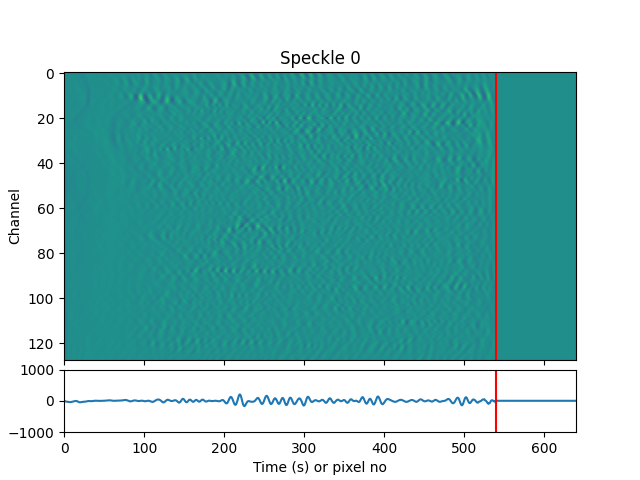

In [18]:
%matplotlib widget


# Load the data
config = json.load(open(path + '/config_calcul.json'))
batch_size = min(config['npulses_total'],500)
file_strs = find_files(path, ext=ext)
file_handles = open_all(file_strs)
speckles = read_map_batch(file_handles, n_pts=config['nx'], batch_size=batch_size, mode=ext)
close_all(file_handles)

nz, nr = config['nz'], config['nx']
time_us = np.array(config['time_us'])
x_scale = np.arange(config['left'],config['right']+1)
if x_type == 'time': x_scale = time_us[x_scale]

# Init plot
fig, ax = plt.subplots(nrows=2, sharex=True)
im = ax[0].imshow(speckles[0], vmin=-1000, vmax=1000)
ln, = ax[1].plot(speckles[0,64,:])
ro1, = ax[0].plot([config['right'],config['right']], [0, nz-1], 'r')
ro2, = ax[1].plot([config['right'],config['right']], [-1000, 1000], 'r')
tit = ax[0].set_title(f'Speckle {0}')
ax[1].set_ylim([-1000,1000])

# Formatting (static)
ax[1].set_xlabel('Time (s) or pixel no')
ax[0].set_ylabel('Channel')
ax[1].set_position((0.10,0.10,0.8,0.13))
ax[0].set_position((0.10,0.25,0.8,0.60))
ax[0].set_aspect('auto')

# Update function
def update(sp_no=0, vamp=1000, rot_pos=config['right']):
    im.set_data(speckles[sp_no])
    ln.set_ydata(speckles[sp_no, 64,:])
    im.set_clim(-vamp, vamp)
    ro1.set_xdata([rot_pos, rot_pos])
    ro2.set_xdata([rot_pos, rot_pos])
    ax[1].set_ylim((-vamp, vamp))
    tit.set_text(f'Speckle {sp_no}')

interact(update, sp_no=(0, batch_size), vamp=(500,2000), rot_pos=(config['right']-100, config['right']+100));

### Velocity maps

/tmp/ipykernel_1907091/4224049907.py:8: RuntimeWarning: Mean of empty slice
  ax[0,0].imshow(np.nanmean(velocity, axis=1), extent=extent)
/tmp/ipykernel_1907091/4224049907.py:10: RuntimeWarning: Mean of empty slice
  ax[0,2].imshow(np.nanmean(score, axis=1), extent=extent)


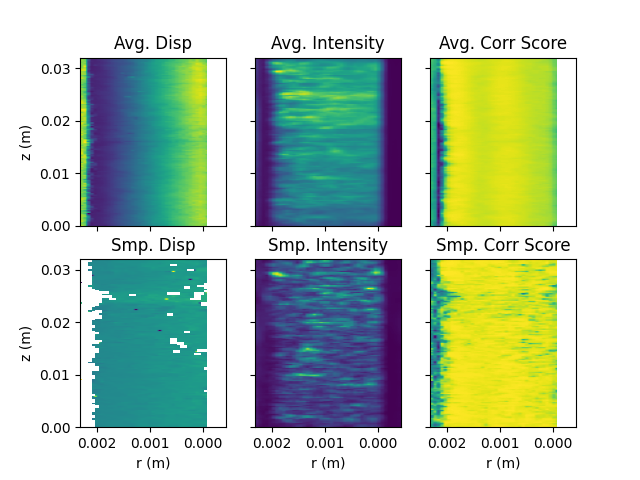

In [19]:
# Load data
data = np.load(path + '/processed.npz')
r_true, velocity = data['r_true'], data['velocity']
hil, disp, score, ref = data['hil'], data['disp'], data['score'], data['ref']

fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True)
extent = [r_true[0], r_true[-1], 0, config['nz']*config['dz']]
ax[0,0].imshow(np.nanmean(velocity, axis=1), extent=extent)
ax[0,1].imshow(hil.mean(axis=1), extent=extent)
ax[0,2].imshow(np.nanmean(score, axis=1), extent=extent)
ax[0,0].set_title('Avg. Disp')
ax[0,1].set_title('Avg. Intensity')
ax[0,2].set_title('Avg. Corr Score')
ax[1,0].imshow(disp[:,0,:], extent=extent)
ax[1,1].imshow(hil[:,0,:], extent=extent)
ax[1,2].imshow(score[:,0,:], extent=extent)
ax[1,0].set_title('Smp. Disp')
ax[1,1].set_title('Smp. Intensity')
ax[1,2].set_title('Smp. Corr Score')
ax[1,0].set_xlabel('r (m)')
ax[1,1].set_xlabel('r (m)')
ax[1,2].set_xlabel('r (m)')
ax[0,0].set_ylabel('z (m)')
ax[1,0].set_ylabel('z (m)')

for a in ax.flat:
    a.set_aspect('auto')

### Velocity

As discussed in `Calib.ipynb`, There is a factor 1/2 in the velocity determination, present in Sébastien / Vincent / Thomas's code. I do not think this factor should be there based on the papers they wrote. It could be a mistake on their part, or an issue with my implementation (but I did really check for those $c_0/2$ instead of $c_0$). I am also putting it here when I plot the velocity.

In [20]:
path

'Data/gpt_5'

/tmp/ipykernel_1907091/4106808666.py:8: RuntimeWarning: Mean of empty slice
  v_profile = np.nanmean(np.nanmean(velocity, axis=0), axis=0) / 2 # NOTE : see markdown above


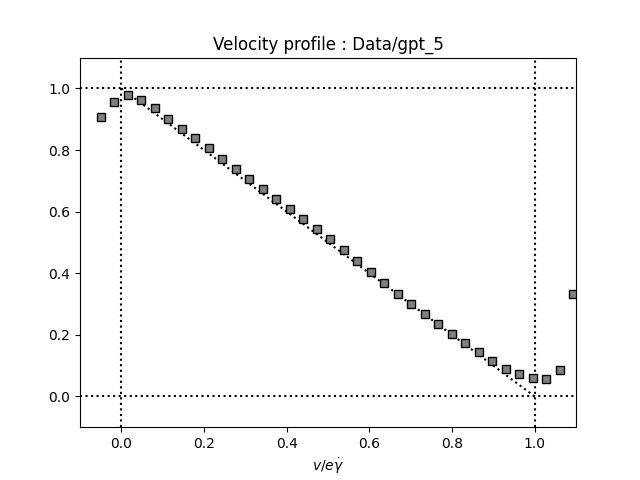

In [22]:
gpt = 5
gap = 2 * 1e-3

# Load data
data = np.load(path + '/processed.npz')
config
r_true, velocity = data['r_true'], data['velocity']
v_profile = np.nanmean(np.nanmean(velocity, axis=0), axis=0) / 2 # NOTE : see markdown above

fig, ax = plt.subplots()
ax.plot([1,0],[0,1], 'k:')
ax.plot([1,1],[-0.1,1.1], 'k:')
ax.plot([0,0],[-0.1,1.1], 'k:')
ax.plot([-0.1,1.1], [0,0], 'k:')
ax.plot([-0.1,1.1], [1,1], 'k:')
ax.plot(r_true/gap, v_profile/(gap*gpt), 's', markerfacecolor='gray', markeredgecolor='black')
ax.axis([-0.1,1.1,-0.1,1.1])
ax.set_title(f'Velocity profile : {path}')
ax.set_xlabel('$r / e$')
ax.set_xlabel('$v / e \\dot\\gamma$');

### Displacement profiles and comparison with MATLAB

In [ ]:
dat = loadmat(path + '/Dpl.mat')
h = loadmat(path + '/Concentration.mat')
cc = loadmat(path + '/config_calcul.mat')

dat = dat['Dpl']
h = h['Hil_moy']

dat[dat > 1e5] = np.nan
mat_d_profile = np.nanmean(np.nanmean(dat, 2), 0)
mat_h_profile = np.nanmean(np.nanmean(h, 2), 1) * 4096
d_profile = np.nanmean(np.nanmean(disp, axis=0),axis=0)
h_profile = hil.mean(axis=0).mean(axis=0)
s_profile = score.mean(axis=0).mean(axis=0) 

x = np.arange(len(d_profile))

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
ax[0].plot(mat_d_profile, '-+', label='MATLAB Ref')
ax[0].plot(x+1,0.1+d_profile/1.1, 'r-x', label='Python')
ax[1].plot(h_profile,  'r-+', label='Python')
ax[1].plot(mat_h_profile,  '-x', label='MATLAB Ref')
ax[2].plot(s_profile, '-+')
ax[0].set_title('Displacement')
ax[1].set_title('Intensity')
ax[2].set_title('Corr Score');